## Importación de bibliotecas e inicialización de los parámetros

1. Importamos las bibliotecas necesarias

In [1]:
import numpy as np
import pandas as pd
import sklearn
import math
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from IPython.display import Latex


2. Inicializamos las variables

In [16]:
train_data =pd.read_csv("basesDatosPr3IMC/csv/train_spam.csv", header=None)
test_data = pd.read_csv("basesDatosPr3IMC/csv/test_spam.csv", header = None)
l2 = False
ratio_rbf = 0.5
eta = 10**-5
classification = True
outputs = 1

## Ejecutamos el algoritmo

-----------
Semilla: 100
-----------
Número de RBFs utilizadas: 2000
---------------------------
MSE de entrenamiento: 0.000250
MSE de test: 0.013000
CCR de entrenamiento: 99.98%
CCR de test: 98.70%
-----------
Semilla: 200
-----------
Número de RBFs utilizadas: 2000
---------------------------
MSE de entrenamiento: 0.000250
MSE de test: 0.013000
CCR de entrenamiento: 99.98%
CCR de test: 98.70%
-----------
Semilla: 300
-----------
Número de RBFs utilizadas: 2000
---------------------------
MSE de entrenamiento: 0.000250
MSE de test: 0.014000
CCR de entrenamiento: 99.98%
CCR de test: 98.60%
-----------
Semilla: 400
-----------
Número de RBFs utilizadas: 2000
---------------------------
MSE de entrenamiento: 0.000250
MSE de test: 0.014000
CCR de entrenamiento: 99.98%
CCR de test: 98.60%
-----------
Semilla: 500
-----------
Número de RBFs utilizadas: 2000
---------------------------
MSE de entrenamiento: 0.000250
MSE de test: 0.013000
CCR de entrenamiento: 99.98%
CCR de test: 98.70%

****

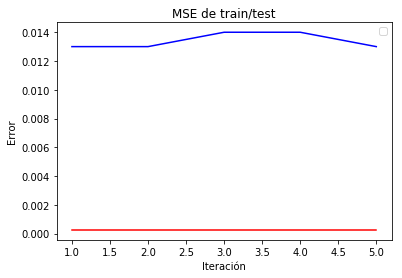

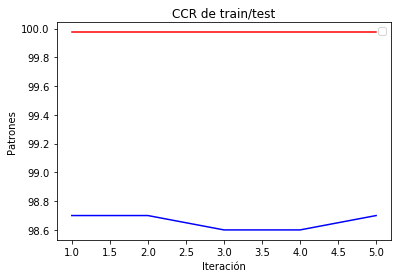

CCR de entrenamiento: 99.98% +- 0.00%
CCR de test: 98.66% +- 0.05%
La matriz de confusión es la siguiente:


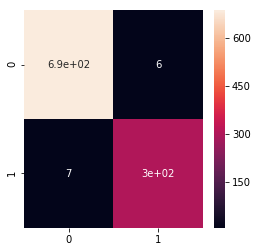

In [17]:
train_mses = np.empty(5)
train_ccrs = np.empty(5)
test_mses = np.empty(5)
test_ccrs = np.empty(5)

for s in range(100,600,100):   
    print("-----------")
    print("Semilla: %d" % s)
    print("-----------")     
    np.random.seed(s)
    train_mses[s//100-1], test_mses[s//100-1], train_ccrs[s//100-1], test_ccrs[s//100-1], matriz_confusion = \
        entrenar(train_data, test_data, classification, ratio_rbf, l2, eta, outputs)
    print("MSE de entrenamiento: %f" % train_mses[s//100-1])
    print("MSE de test: %f" % test_mses[s//100-1])
    if classification:
        print("CCR de entrenamiento: %.2f%%" % train_ccrs[s//100-1])
        print("CCR de test: %.2f%%" % test_ccrs[s//100-1])

print("\n*********************")
print("Resumen de resultados")
print("*********************")
print("MSE de entrenamiento: %f +- %f" % (np.mean(train_mses), np.std(train_mses)))
print("MSE de test: %f +- %f" % (np.mean(test_mses), np.std(test_mses)))

plt.title("MSE de train/test")
plt.xlabel("Iteración")
plt.ylabel("Error")
plt.legend(('train', 'test'))
plt.plot(np.arange(1, train_mses.shape[0]+1), train_mses, 'r')
plt.plot(np.arange(1, test_mses.shape[0]+1), test_mses, 'b')
plt.show()
    
if classification:
    plt.xlabel("Iteración")
    plt.ylabel("Patrones")
    plt.title("CCR de train/test")
    plt.legend(('train', 'test'))
    plt.plot(np.arange(1, train_mses.shape[0]+1),train_ccrs, 'r')
    plt.plot(np.arange(1, test_mses.shape[0]+1),test_ccrs, 'b')
    plt.show()
    
    print("CCR de entrenamiento: %.2f%% +- %.2f%%" % (np.mean(train_ccrs), np.std(train_ccrs)))
    print("CCR de test: %.2f%% +- %.2f%%" % (np.mean(test_ccrs), np.std(test_ccrs)))
    print("La matriz de confusión es la siguiente:")
   
    plt.figure(figsize = (4,4))
    sn.heatmap(matriz_confusion, annot=True)
    plt.show()

## Funciones necesarias

1. Inicializamos las variables de train y de test

In [3]:
def inicializarDatos(train_data, test_data, outputs):
    train_inputs = train_data.values[:, 0:-outputs];
    train_outputs = train_data.values[:, -outputs];#Guarda las clases existentes

    test_inputs = test_data.values[:, 0:-outputs];
    test_outputs = test_data.values[:, -outputs];
    
    return train_inputs, train_outputs, test_inputs, test_outputs

2. Esta función calculará los centroides de cada una de las rbfs de manera estratificada. Para ello, utilizamos la función StratifiedShuffleSplit. Seguidamente, recorremos la variable devuelta por esta función que contiene los centroides estratificados. Finalmente, barajamos dichos centroides.

In [4]:
def inicializar_clas(train_inputs, train_outputs, num_rbfs):
    sss = StratifiedShuffleSplit(n_splits=num_rbfs, test_size=None, train_size=num_rbfs, random_state=0)

    for train_index, test_index in sss.split(train_inputs, train_outputs):
        centroides = train_inputs[train_index,:]
    
    indice = 0
   
    while centroides.shape[0] < num_rbfs:        
        centroides = np.r_[centroides, [train_inputs[test_index[indice]]]] 
        indice += 1
        
    while centroides.shape[0] > num_rbfs:
        centroides = centroides[np.random.choice(centroides.shape[0], num_rbfs,0),:]
    return centroides

3. En esta función hay que dividir dos partes, la primera, el caso de clasificación. Los centroides serán seleccionados de manera estratificada, para ello, realizamos una llamada a la función inicializar_clas, la cual inicializará dichos centroides. La segunda, el caso de regresión, los centroides serán seleccionados de manera aleatoria utilizando la función random.choice de la biblioteca numpy

In [5]:
def clustering(classification, train_inputs, train_outputs, num_rbfs):
    if classification == True:
        centros = inicializar_clas(train_inputs, train_outputs, num_rbfs)
    else:
        centros = train_inputs[np.random.choice(train_inputs.shape[0], num_rbfs, replace=False), :]
    
    kmedias = KMeans(n_init=1, max_iter=500, n_clusters=num_rbfs, init=centros).fit(train_inputs)
    centros = kmedias.cluster_centers_
    distancias = kmedias.transform(train_inputs)
    
    return kmedias, distancias, centros

4. La siguiente función calculará cada una de las distancias existentes entre los centroides y los demás patrones. Para ello se hará uso de la función squareform, que calcula la distancia euclídea de los centroides con respecto a cada uno de los patrones. Por último, se calcula la media de la suma de todas las distancias y se dividirá entre 2*num_rbfs-1, resultando la siguiente ecuación:

$$\sigma_{j} = \frac{1}{2*(num\_rbfs-1)} * \Sigma_{i\neq j}\sqrt{\Sigma_{d=1}^{n}(c_{jd}-d_{id})^2}$$
===

In [6]:
def calcular_radios(centroides, num_rbfs):
    distancias_centros = squareform(pdist(centroides, 'euclidean'))
    radios = distancias_centros.sum(axis=1)
    radios = radios/(2*num_rbfs-1)
    
    return radios

5. La función calcular_matriz_r calculará la matriz de salidas con la que entrenaremos nuestra red una vez alimentada con patrones. Para ello, utilizaremos una función gaussiana como la siguiente:
$$\varphi(\textbf{x,c}, \sigma) = exp(-\frac{distancia}{2\sigma^2})$$
===

In [7]:
def calcular_matriz_r(distancias, radios):
    matriz_r = np.ones(shape = (distancias.shape[0], distancias.shape[1]+1))
    matriz_r[:,:-1] =  np.exp(-(distancias**2)/(2*(np.power(radios, 2))))

    return matriz_r

6. La siguiente función calcula la matriz pseud-inversa de Moore Penrose, que corresponede con la siguiente fórmula:
$$\beta^{T}_{(n_1+1)*k} = (R^{+})_{(n_1+1)*N} Y_{N*k}$$
===
Para ello, utilizaremos la función linalg.pinv de la librería numpy para poder calcular dicha pseudo-inversa. Además, como hemos visto, realizamos un producto escalar con respecto a la salida de train y por último calculamos su transpuesta

In [8]:
def invertir_matriz_r(matriz_r, train_outputs):
    
    coefficients = np.transpose(np.dot(np.linalg.pinv(matriz_r), train_outputs))
    
    return coefficients

7. Esta función calculará la regresión logística de nuestra matriz de salidas. Dependiendo de si la bandera l2 está activa, utilizará una logística u otra. En el caso de ser True, utilizará una logística de tipo L2, en caso contrario, utilizará una logística de L1

In [9]:
def calculate_logreg(matriz_r_train, train_outputs, eta, l2):
    if l2 == True:
        logreg = LogisticRegression(penalty='l2', C=1/eta, solver='liblinear', fit_intercept=False).fit(matriz_r_train,train_outputs)
    else:
        logreg = LogisticRegression(penalty='l1', C=1/eta, solver='liblinear', fit_intercept=False).fit(matriz_r_train,train_outputs)
    
    return logreg

8. Esta función entrena nuestra red con los parámetros iniciales. Devuelve el error devuelto por nuestra red y si es un problema de clasificación, devolverá el porcentaje de CCR y la matriz de confusión resultantes de nuestro entrenamiento

In [10]:
def entrenar(train_data, test_data, classification, ratio_rbf, l2, eta, outputs):
    #Capa de entrada
    train_inputs, train_outputs, test_inputs, test_outputs = inicializarDatos(train_data, test_data, outputs)

    num_rbfs=int(round(ratio_rbf*len(train_inputs)))  #Multiplicar el ratio por el numero de patrones de train
    print("Número de RBFs utilizadas: %d" %(num_rbfs))
    print("---------------------------")

    kmedias, distancias, centros = clustering(classification, train_inputs, train_outputs, num_rbfs)
    radios = calcular_radios(centros, num_rbfs)
    matriz_r = calcular_matriz_r(distancias, radios)

    if not classification:
        coefficients = invertir_matriz_r(matriz_r, train_outputs)
    else:
        logreg = calculate_logreg(matriz_r, train_outputs, eta, l2)

    distancias_test = kmedias.transform(test_inputs)
    matriz_r_test = calcular_matriz_r(distancias_test, radios)
    
    if not classification:
        predicted_test_aux = np.dot(matriz_r_test, coefficients)
        predicted_train_aux = np.dot(matriz_r, coefficients)
        
        predicted_test= np.round(predicted_test_aux)
        predicted_train= np.round(predicted_train_aux) 

        predicted_test += 0.
        predicted_train += 0.
        
        test_mse = mean_squared_error(test_outputs, predicted_test_aux)
        train_mse = mean_squared_error(train_outputs, predicted_train_aux)
        
        train_ccr = 0
        test_ccr = 0
        matriz_confusion = np.ones(predicted_train.shape)
    else:
        predicted_train = logreg.predict(matriz_r)
        predicted_test = logreg.predict(matriz_r_test)
        
        train_mse = mean_squared_error(predicted_train, train_outputs)
        test_mse = mean_squared_error(predicted_test, test_outputs)
        
        train_ccr = logreg.score(matriz_r, train_outputs)*100
        test_ccr = logreg.score(matriz_r_test, test_outputs)*100
        
        #Calculamos la matriz de confusion
        matriz_confusion = confusion_matrix(test_outputs, predicted_test)
        
    return train_mse, test_mse, train_ccr, test_ccr, matriz_confusion